In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --extra-index-url=https://pypi.nvidia.com cuml-cu12==24.4.*
import cuml

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 GB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.6/126.6 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.1/170.1 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 810.9/810.9 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 102.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 20.0 MB/s eta 0:00:00
  Attempting uninstall: dask
    Found exist

In [ ]:
#!pip install --extra-index-url=https://pypi.nvidia.com cuml-cu12==24.4.*
#!pip install bertopic==0.16.2
#from bertopic import BERTopic
#from bertopic.dimensionality import BaseDimensionalityReduction
#import cuml
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc

colors = {
    1: ['#003f5c'],
    2: ['#003f5c', '#ffa600'],
    3: ['#003f5c', '#bc5090', '#ffa600'],
    4: ['#003f5c', '#7a5195', '#ef5675', '#ffa600'],
    5: ['#003f5c', '#58508d', '#bc5090', '#ff6361', '#ffa600'],
    6: ['#003f5c', '#444e86', '#955196', '#dd5182','#ff6e54', '#ffa600'],
    7: ['#003f5c', '#374c80', '#7a5195', '#bc5090', '#ef5675', '#ff764a', '#ffa600'],
    8: ['#003f5c', '#2f4b7c', '#665191', '#a05195', '#d45087', '#f95d6a', '#ff7c43', '#ffa600']
    }

#import seaborn as sns

In [ ]:
directory = f"/content/drive/MyDrive/Nikta"
path = os.path.join(directory, 'Data', '50k_random_seed_42_embeddings.npy')
embeddings = np.load(path)

In [ ]:
len(embeddings)

50000

In [ ]:
directory = f"/content/drive/MyDrive/Nikta/Data"
path = os.path.join(directory, 'deduplicated_data2.csv')
posts = pd.read_csv(path, encoding = 'utf-8')

In [ ]:
posts.columns

Index(['Id', 'Title', 'Body', 'CreationDate', 'Score', 'ViewCount', 'Tags',
       'AnswerCount', 'CommentCount', 'FavoriteCount', 'CombinedText'],
      dtype='object')

In [ ]:
Titles = posts['Title'].to_list()
Bodies = posts['Body'].to_list()
posts['Combined'] = [f"Title: {Titles[i]}, Body: {Bodies[i]}" for i in range(posts.shape[0])]

In [ ]:
posts = posts.sample(n=5, random_state=42)
posts.index.values[0]

194968

In [ ]:
# Elbow Mehtod to choose k in kmeans for clustering the embeddings for topic modeling
def elbow(embeddings, ks):
    models = []
    for k in tqdm(ks):
        gc.collect()
        model = cuml.KMeans(n_clusters=k, random_state=0)
        model.fit(embeddings)
        models.append(model)
    return models

start = 1
end = 150
step = 1
ks = range(start, end + 1, step)
models = elbow(embeddings, ks=ks)


path = ''
#with open(path, 'wb') as file:
#    pickle.dump(models, file)

100%|██████████| 150/150 [28:15<00:00, 11.30s/it]


In [ ]:
inertias_list = [model.inertia_ for model in models]

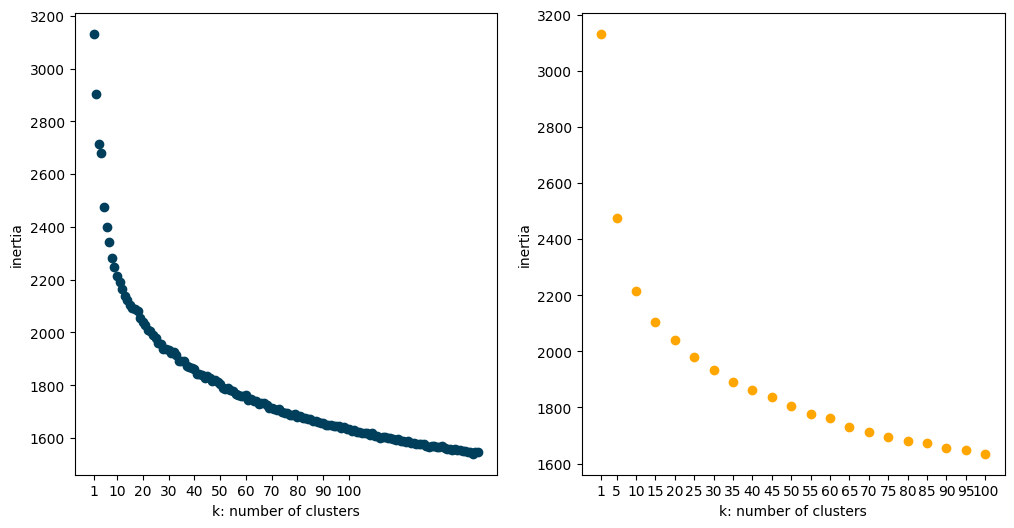

In [ ]:
# Plotting inertia
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

plt.plot(ks, inertias_list, 'o', color = colors[2][0])
plt.xlabel('k: number of clusters')
plt.ylabel('inertia')
plt.xticks([1] + list(range(10, 101, 10)))
plt.title('')
#plt.title('Elbow Method showing the optimal k')


zoom_range = list(range(4, 100, 5)) + [0] #+ list(range(39, 100, 10))

plt.subplot(1, 2, 2)
plt.plot([ks[i] for i in zoom_range], [inertias_list[i] for i in zoom_range], 'o', color = colors[2][1])
plt.xlabel('k: number of clusters')
plt.ylabel('inertia')
#plt.yticks(range(13000, 27000 + 1, 2000))
plt.xticks([i + 1 for i in zoom_range])
plt.title('')

plt.show()

# Topic Modeling

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install --extra-index-url=https://pypi.nvidia.com cuml-cu12==24.4.*
!pip install bertopic==0.16.2
#!pip install bertopic==0.16.0
from bertopic import BERTopic
from bertopic.dimensionality import BaseDimensionalityReduction
import cuml
import os
import numpy as np
#import pandas as pd
#import matplotlib.pyplot as plt
#import seaborn as sns

In [ ]:
import re
import string
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

stopwords = stopwords.words('english')

def preprocess_text(
        text, stop_words = stopwords, lowercase = True, remove_usernames = True, remove_URLs = True, remove_domains_path = True,
        remove_punctuations = True, remove_digits = True, reduce_consecutive_characters = True,
        reduce_immediate_duplicate_words = True, spell_check = True, remove_stop_words = True):

    # Convert text to lowercase
    if(lowercase):
        text = text.lower()

    # Remove @usernames
    if(remove_usernames):
        text = re.sub(r'@\w+', '', text)

    # URL removal
    if(remove_URLs):
        text = re.sub(r'\S*http\S+', '', text)
        text = re.sub(r'\S*www.\S+', '', text)
        text = re.sub(r'\S*/\S+', '', text)

    # Domain/Path Removal
    if(remove_domains_path):
        text = re.sub(r'\S+\.\S+' , '', text)
        text = re.sub(r'\S*\\\S+' , '', text)

    text = re.sub(r'\S*bot\S*', '', text)

    # Consecutive Character Reduction
    if(reduce_consecutive_characters):
        text = re.sub(r'(.)\1{2,}', r'\1', text)

    # Immediate Duplicate Word Removal
    if(reduce_immediate_duplicate_words):
        text = re.sub(r'\b(\w+)(\s+\1){1,}\b', r'\1', text)

    # Spell Checker
    if(spell_check):
        spell = SpellChecker()
        corrected_text = []
        for word in text.split():
            corrected_word = spell.correction(word)
            corrected_text.append(corrected_word if corrected_word else word)
        text = ' '.join(corrected_text)


    # Remove punctuations
    if(remove_punctuations):
        text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove digits
    if(remove_digits):
        text = re.sub(r'\d+', '', text)

    # Remove stop words
    if(remove_stop_words and stop_words):
        text = ' '.join([word for word in text.split() if word not in stop_words])

    # Whitespace Normalization
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
cleaned_messages = [preprocess_text(
        message, stop_words = stopwords, lowercase = True, remove_usernames = True, remove_URLs = True, remove_domains_path = True,
        remove_punctuations = True, remove_digits = True, reduce_consecutive_characters = False,
        reduce_immediate_duplicate_words = True, spell_check = False, remove_stop_words = True) for message in messages]

In [ ]:
# This needs cuml
from sklearn.feature_extraction.text import CountVectorizer

empty_dimensionality_model = BaseDimensionalityReduction()
kmeans = cuml.KMeans(n_clusters=36, random_state=0)
vectorizer_model = CountVectorizer(ngram_range=(1, 2), max_df = 0.4)
k = 36

kmeans = cuml.KMeans(n_clusters=k, random_state=0) # this needs graphics card and cuda
#kmeans = KMeans(n_clusters=k, random_state=0) # Slow CPU version
topic_model = BERTopic(umap_model=empty_dimensionality_model, hdbscan_model=kmeans, verbose=True, top_n_words=10, vectorizer_model = vectorizer_model)
topics, _ = topic_model.fit_transform(cleaned_messages, embeddings)